In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from harp_resources import process, utils
from analysis_functions import *

In [4]:
Grab_MM_1 = pd.read_csv('GRAB_MMclosed_open_session1.csv')

/var/folders/j0/v9b_1b8d44l7jr8z9bvwrg4h0000gp/T/ipykernel_68288/3915672200.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  Grab_MM_1 = pd.read_csv('GRAB_MMclosed_open_session1.csv')


In [5]:
# Chaning event name to halt and making it so that its True when there is a halt
#Grab_MM_1.loc[:, 'event'] = Grab_MM_1['event'].replace({False: True, True: False})
Grab_MM_1.rename(columns = {'event': 'halt'}, inplace = True)


In [6]:
#Make sure the index provides inforamtion of seconds since start
Grab_MM_1.set_index('Seconds', inplace=True)
# Theres only photomotry information from 15 seconds due to bleaching
Grab_MM_1 = Grab_MM_1.loc[ Grab_MM_1.index>30]

In [7]:
# Convert the Seconds column to a timedelta format, keeping milliseconds
#Grab_MM_1['Time'] = pd.to_timedelta(Grab_MM_1['Seconds'], unit='s')

# Set this new 'Time' column as the index
#Grab_MM_1.set_index('Time', inplace=True)

# Verify
#print(Grab_MM_1)

In [38]:
def view_session_mouse(mousedata, mouse):
    print('\033[1m'+f'Plotted traces for {mouse}'+'\033[0m')
    plotlist = ['470_dfF', 'movementX']#movementY, eye_center_x, eye_center_y, eye_diameter,
    fig, axs = plt.subplots(len(plotlist), figsize=(15,10), sharex=True)  # sharex=True for a shared x-axis
    #color = plt.cm.cividis(np.linspace(0, 1, len(plotlist)))
    color = ['forestgreen', 'blue']
    time = mousedata.index
    event = mousedata.halt
    
    # Iterate over the subplots and plot the traces
    for i, (ax, trace) in enumerate(zip(axs, plotlist)):
        ax.plot(time, mousedata[trace], color=color[i], label=trace)
        ax.set_title(trace)
        
        # Plot shaded areas for each halt event
        ymin, ymax = ax.get_ylim()
        halt = ax.fill_between(time, ymin, ymax, where=event, color='grey', alpha=0.3)
    
    halt.set_label('halt')
    
    # Plot a horizontal line for LinearNormal_block and LinearMismatch_block on a shared x-axis at the bottom
    # We use the last axis (axs[-1]) to plot these lines, but we can adjust their y-position below the subplots
    #trans = ax.get_xaxis_transform()
    block_colors = ['lightsteelblue', 'lightcoral', 'forestgreen']
    colorcount = 0
    for col in mousedata:
        if '_block' in col:
            start = mousedata.loc[mousedata[col] == True].index[0]
            end = mousedata.loc[mousedata[col] == True].index[-1]
    
            min = ax.get_xlim()[0]
            max = ax.get_xlim()[1]
    
            norm_start = norm(start, min, max)
            norm_end = norm(end, min, max)
    
            ax.text(norm_start+0.05, -0.2, col, transform=ax.transAxes,fontsize=10, verticalalignment='top')
    
            ax.add_patch(Rectangle((norm_start, -0.15), norm_end - norm_start, -0.2, facecolor= block_colors[colorcount],
                                   alpha = 0.5, label=col, clip_on = False, transform=ax.transAxes))# **kwargs))
            
            #plt.hlines(-20,xmin=start, xmax=end, linewidth=5, color=colorlist[colorcount], alpha = 0.5, label= f'{col}')
            colorcount+=1
    
    # Create one legend for the figure for the 'halt' label
    fig.legend(fontsize=12)
    
    # Update font size and layout
    plt.rcParams.update({'font.size': 10})
    fig.tight_layout(pad=1.08)
    plt.show()


In [39]:
Grab_MM_1.mouseID.unique()

array(['B2M6', 'B3M8', 'B3M7', 'B3M6', 'B3M4'], dtype=object)

Plotted traces for B2M6


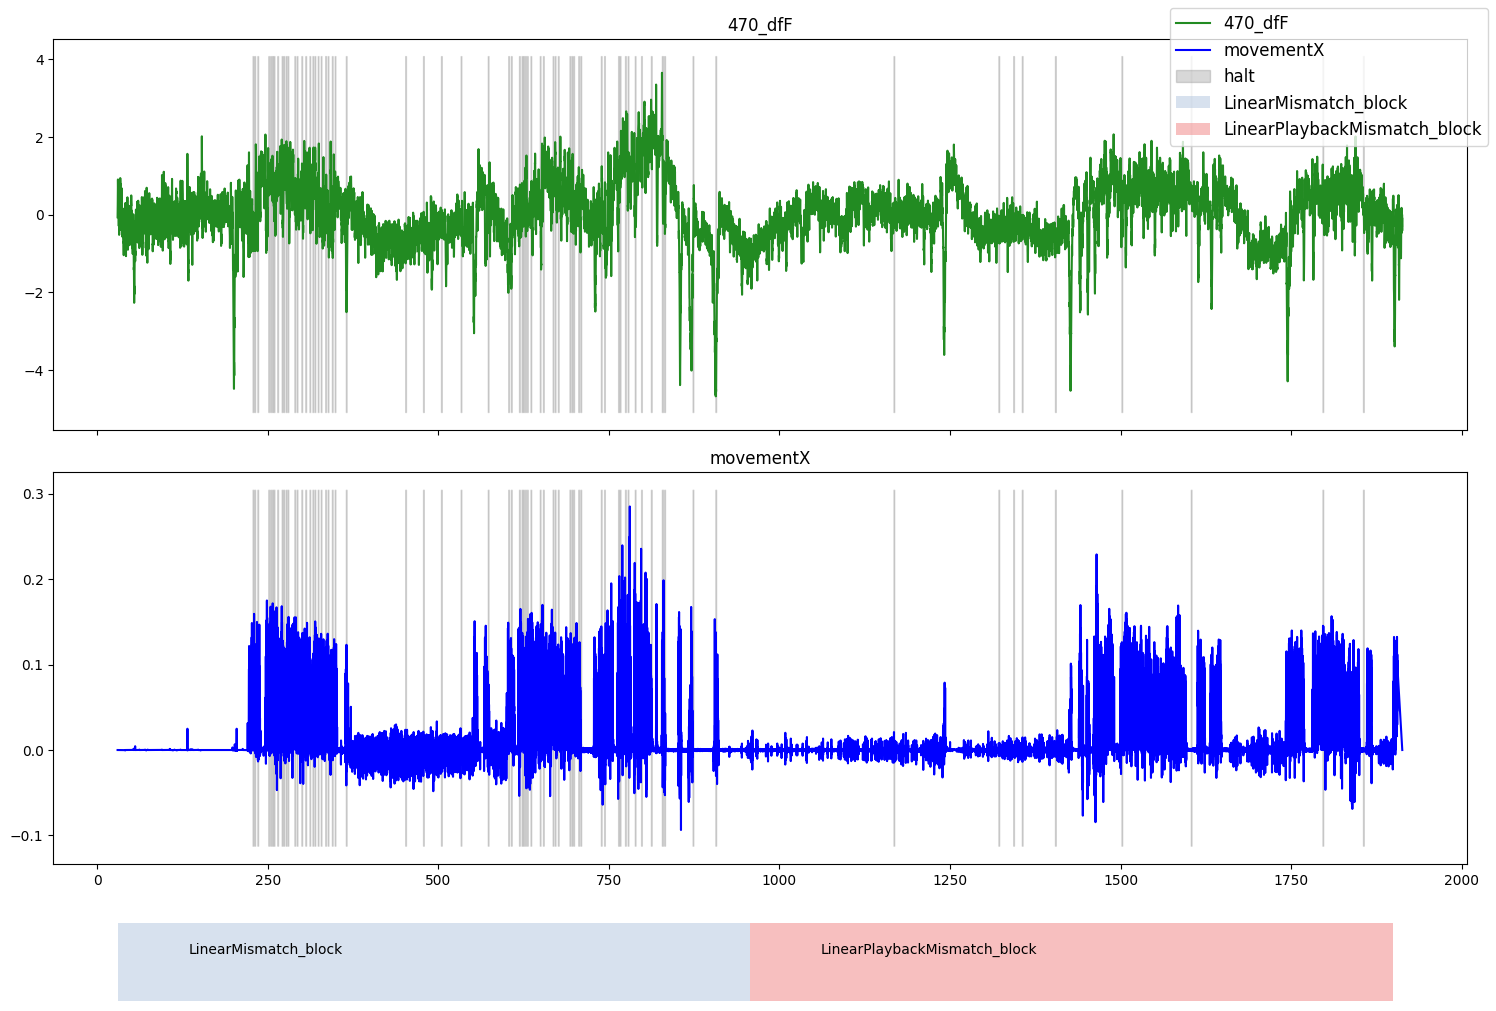

Plotted traces for B3M8


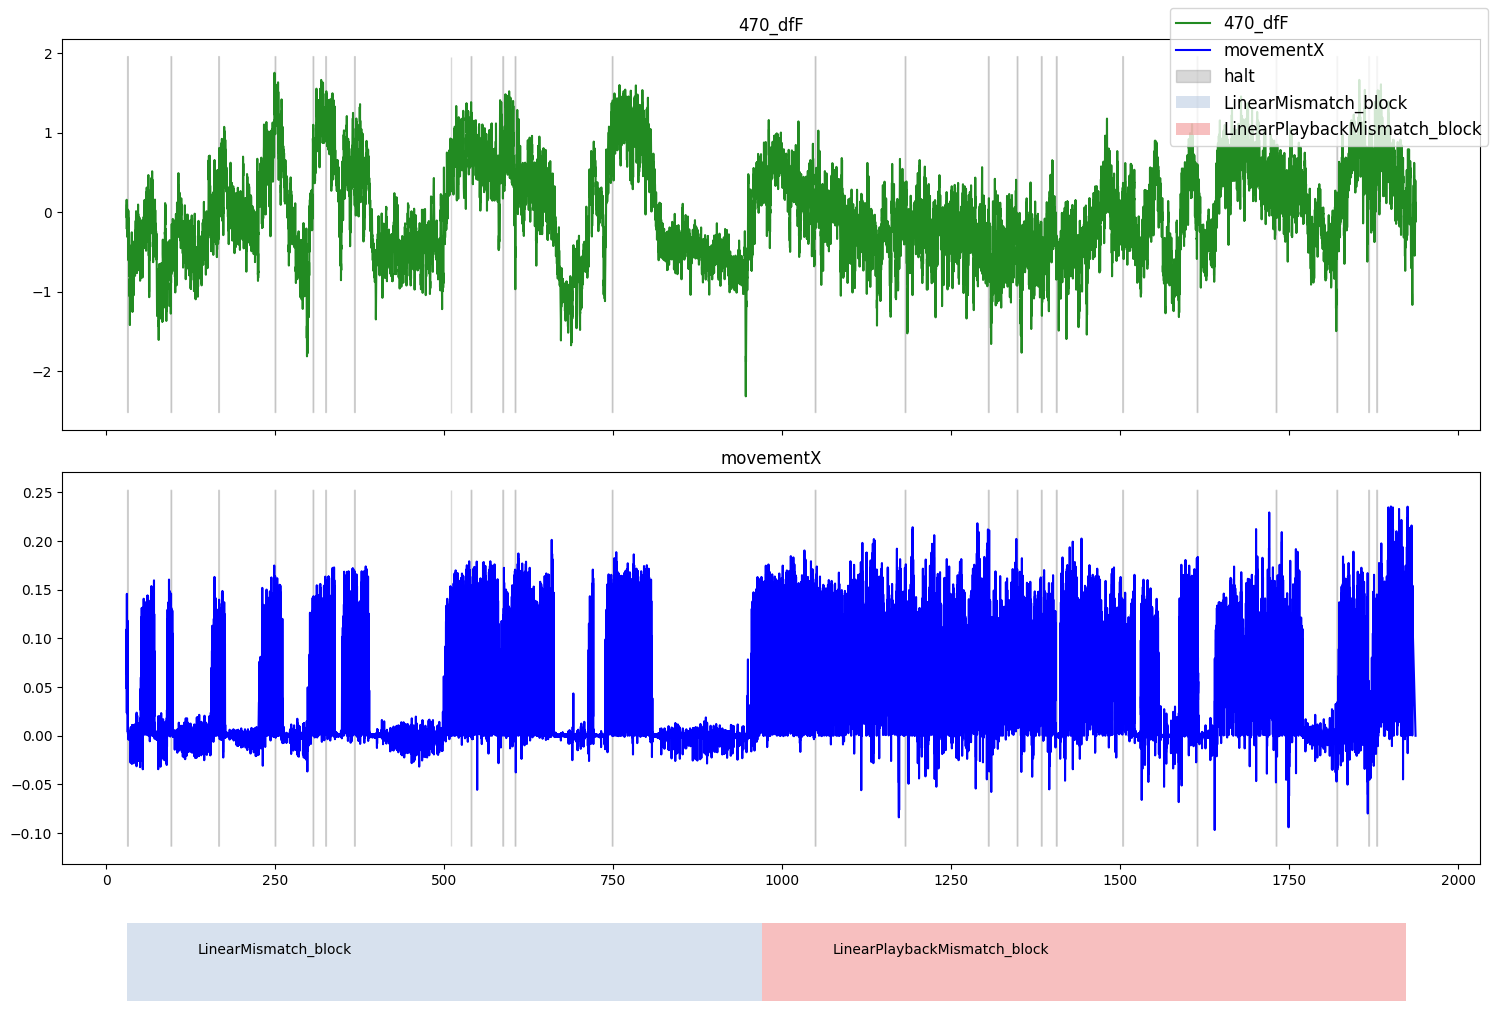

Plotted traces for B3M7


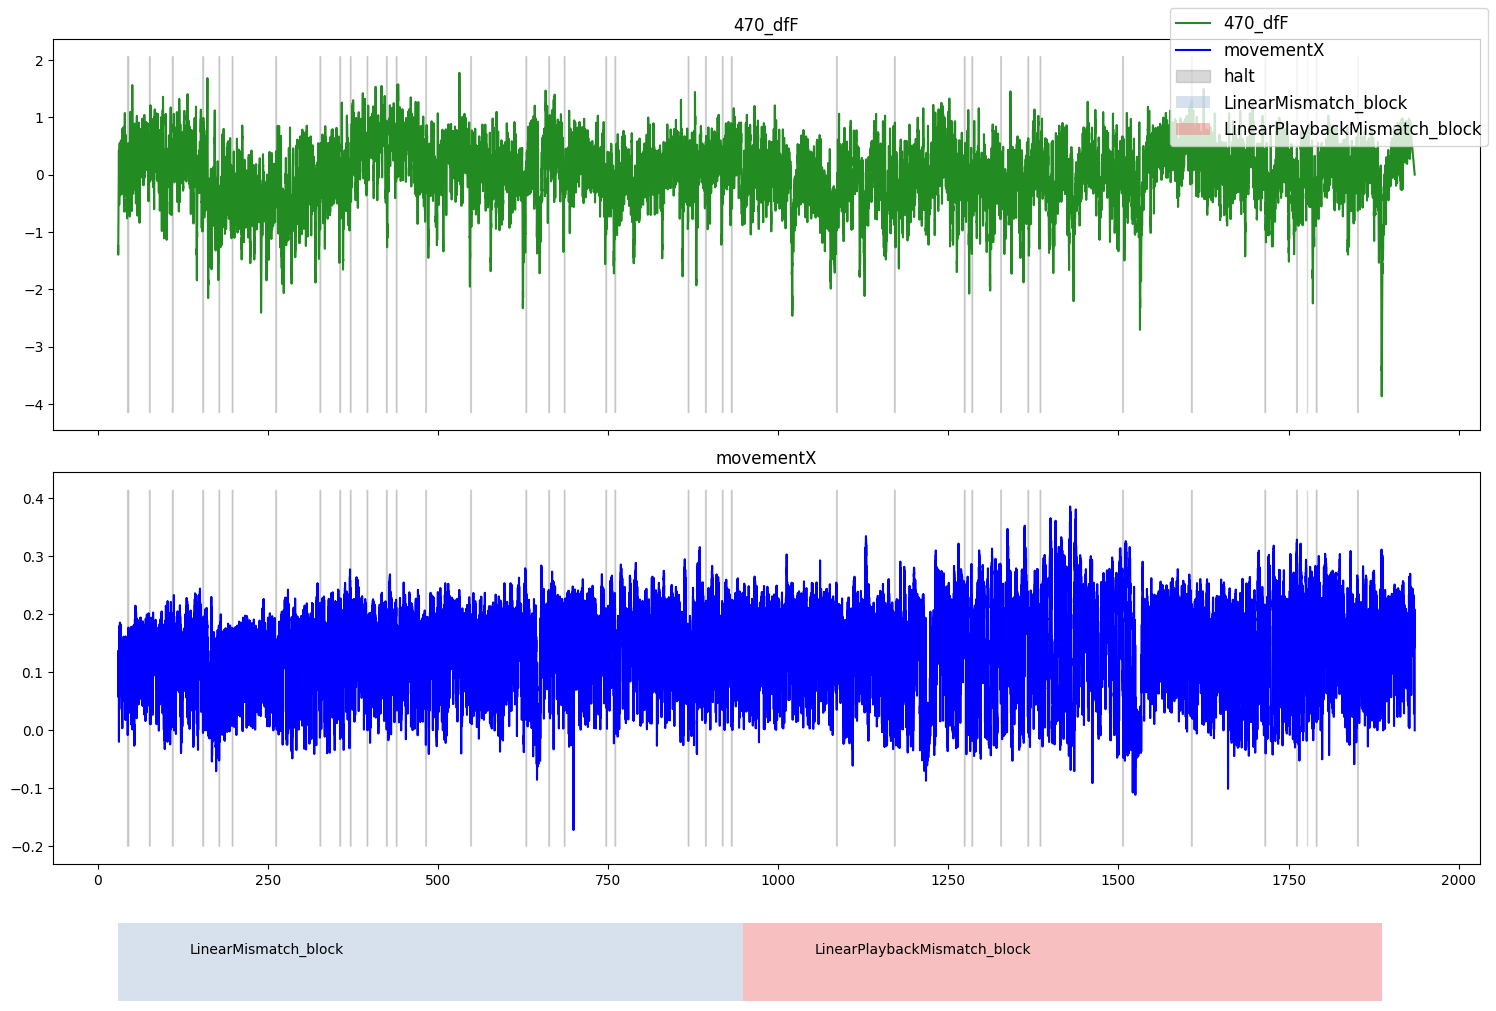

Plotted traces for B3M6


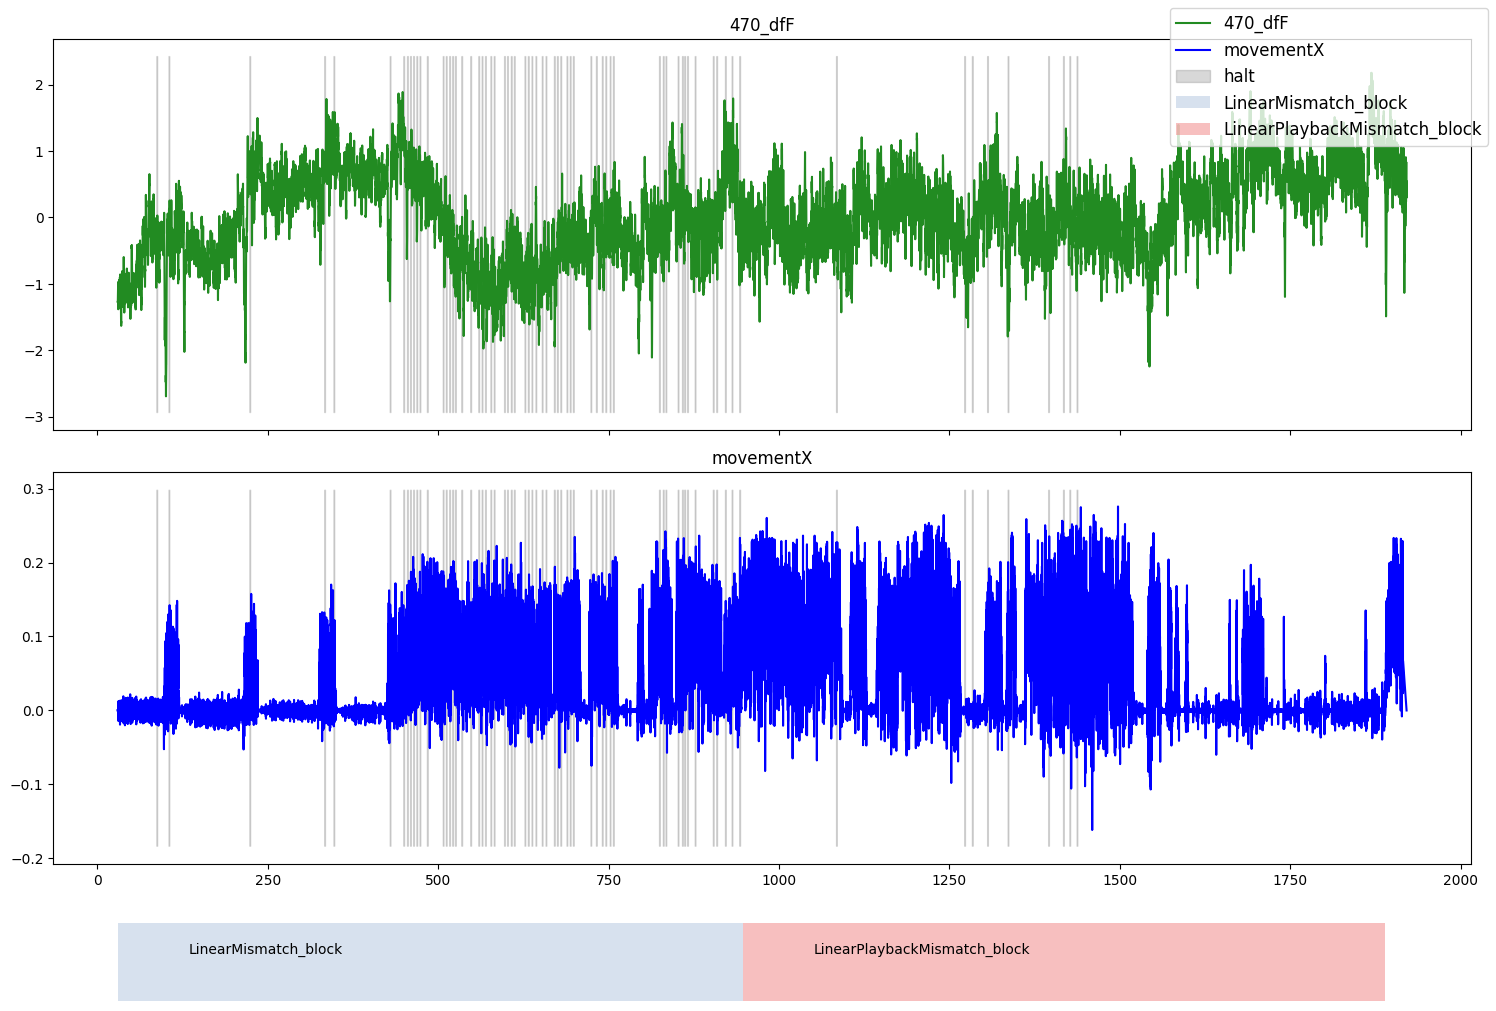

Plotted traces for B3M4


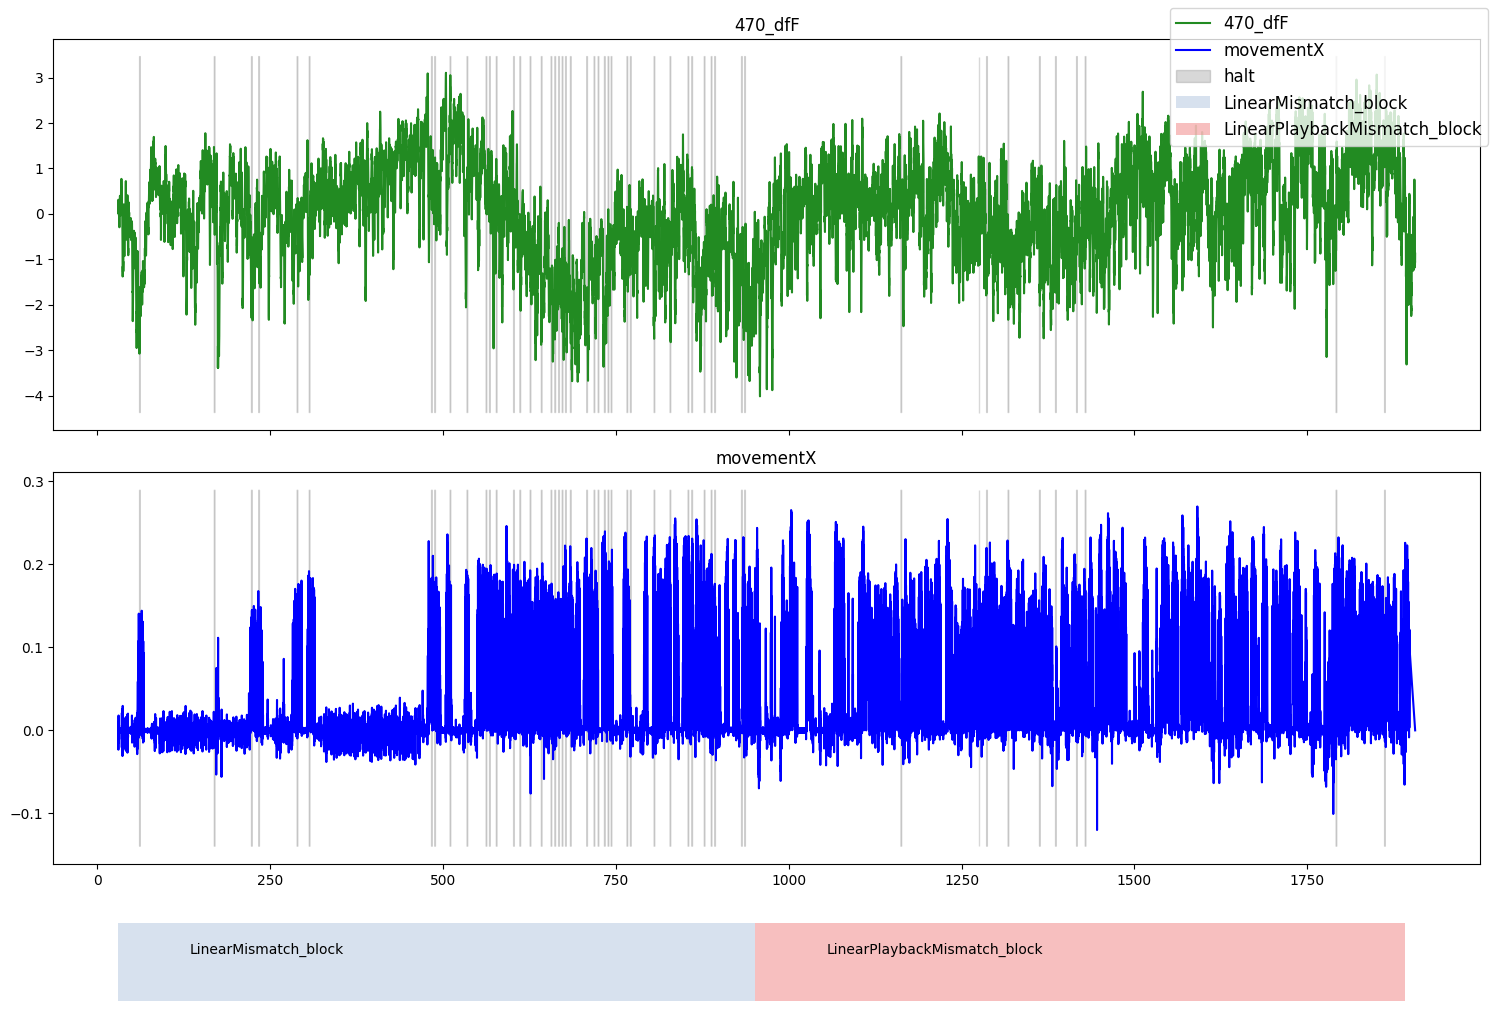

In [40]:
#pick a mouse
for mouse in Grab_MM_1.mouseID.unique():
    mouse_data = Grab_MM_1.loc[Grab_MM_1.mouseID == mouse]
    view_session_mouse(mouse_data, mouse)

In [254]:
#event_starts = (B2M6_Grab_MM_1['halt'] & ~B2M6_Grab_MM_1['halt'].shift(1, fill_value=True))  # Detect where True starts
#event_ends = (~B2M6_Grab_MM_1['halt'] & B2M6_Grab_MM_1['halt'].shift(1, fill_value=False))  # Detect where True ends

In [255]:
#event_starts.loc[event_starts == True]
#event_ends.loc[event_ends == True]

In [256]:
#Maybe fit a regression to see how much of the variation in fluorescence can be explained by running and block and so on
#Maybe also halt frequency, by randomly making blocks of a few seconds during which the halt frequency is calculated 
#(could be difficult, as two period blocks next to eachother could be sampled to low rate, while one could actually consider them high rate)
#Maybe theres a way to get a continous measure of rate

#look for different direction in correlation between running and fluorescence during the different blocks


In [10]:
#Filter mice to get unique indexes
mouse_closedloop = {}
mouse_openloop = {}
for mouse in Grab_MM_1.mouseID.unique():
    mouse_closedloop[mouse] = filter_data(Grab_MM_1, filters = [mouse, 'closed_block'])
    mouse_openloop[mouse] = filter_data(Grab_MM_1, filters = [mouse, 'open_block'])

In [11]:
mouse_closedloop

{'B2M6':           470_dfF  movementX  movementY   halt     ExperimentEvents  \
 Seconds                                                               
 30.001  -0.068699   0.000000        0.0  False                  NaN   
 30.002  -0.064503   0.000000        0.0  False                  NaN   
 30.003  -0.060307   0.000000        0.0  False                  NaN   
 30.004  -0.056110   0.000000        0.0  False                  NaN   
 30.005  -0.051914   0.000000        0.0  False                  NaN   
 ...           ...        ...        ...    ...                  ...   
 956.866 -1.367239   0.000448        0.0  False                  NaN   
 956.867 -1.366856   0.000448        0.0  False                  NaN   
 956.868 -1.366473   0.000448        0.0  False                  NaN   
 956.869 -1.366089   0.000448        0.0  False                  NaN   
 956.870 -1.365706   0.000448        0.0  False  Block timer elapsed   
 
                 Experiment Session mouseID sex area  

In [87]:
def select_perievent_segment(df, trace, event_col, range_around_event):
    
    selected_trace_chunks = pd.DataFrame()
    
    event_times = df.loc[df[event_col] & ~df[event_col].shift(1, fill_value=False)].index

    before_0 = range_around_event[0]
    after_0 = range_around_event[1]

    for event_time in event_times:
        
        
        start = event_time - before_0
        end = event_time + after_0

        chunk = df[trace].loc[start:end]
        chunk.index = (chunk.index - chunk.index[0]) - before_0 # making the index range from
        print(chunk)
        selected_trace_chunks[event_time]=chunk
        
        
    return selected_trace_chunks

In [88]:
selected_chunks = select_perievent_segment(B3M8, '470_dfF', 'halt',[1,2])

Seconds
-1.000    0.002546
-0.999    0.003640
-0.998    0.004735
-0.997    0.005830
-0.996    0.006924
            ...   
 1.995   -0.328067
 1.996   -0.326890
 1.997   -0.325713
 1.998   -0.324536
 1.999   -0.323359
Name: 470_dfF, Length: 3000, dtype: float64
Seconds
-1.000   -0.747898
-0.999   -0.749724
-0.998   -0.751551
-0.997   -0.753378
-0.996   -0.755204
            ...   
 1.996   -0.485698
 1.997   -0.486452
 1.998   -0.487205
 1.999   -0.487959
 2.000   -0.488712
Name: 470_dfF, Length: 3001, dtype: float64
Seconds
-1.000   -0.064179
-0.999   -0.065463
-0.998   -0.066747
-0.997   -0.068031
-0.996   -0.069315
            ...   
 1.996    0.455440
 1.997    0.458695
 1.998    0.461951
 1.999    0.465206
 2.000    0.468462
Name: 470_dfF, Length: 3001, dtype: float64
Seconds
-1.000    1.683998
-0.999    1.685119
-0.998    1.686239
-0.997    1.687360
-0.996    1.688480
            ...   
 1.996    1.256204
 1.997    1.255923
 1.998    1.255642
 1.999    1.255361
 2.000    1.255080


In [86]:
selected_chunks 

,31.514,95.730,166.313,249.779,305.895,324.662,367.278,510.080,539.777,586.710,...,1304.987,1347.570,1383.353,1405.569,1503.702,1613.818,1730.667,1820.583,1867.632,1879.549
Seconds,,,,,,,,,,,,,,,,,,,,,
-1.000,0.002546,-0.747898,-0.064179,1.683998,0.152461,1.02521,0.734439,0.745677,0.69699,0.587008,...,-0.282378,-0.585291,-0.28588,-0.203965,-0.315706,-0.009565,0.193542,-1.460235,0.134084,0.367283
-0.999,0.003640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.998,0.004735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.997,0.005830,-0.753378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.996,0.006924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.995,-0.328067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.996,-0.326890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.997,-0.325713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
def align_to_event_start(df, trace, event_col, range_around_event):
    
    trace_chunks = pd.DataFrame()
    bsl_trace_chunks = pd.DataFrame()
    
    # Identify the start times for each event
    event_times = df.loc[df[event_col] & ~df[event_col].shift(1, fill_value=False)].index
    
    # Calculate the time range around each event
    before_0 = range_around_event[0]
    after_0 = range_around_event[1]
    
    # Calculate the target length of each chunk based on the sampling rate
    sampling_rate = 0.001
    target_length = int(((before_0+after_0)/sampling_rate)+1) #add 1 due to ranges including both ends (0 -> 5 is 6 values not 5)
    print(target_length)
    for event_time in event_times:
        
        # Determine the time range for each chunk
        start = event_time - before_0
        end = event_time + after_0
        
        # Extract the chunk from the trace column
        chunk = df[trace].loc[start:end]
        
        # Normalize the index to start at -before_0
        chunk.index = (chunk.index - chunk.index[0]) - before_0
        Index = chunk.index
        # Check if the chunk is shorter than the target length
        if len(chunk) < target_length:
            # Pad the chunk with NaN values at the end to reach the target length
            padding = pd.Series([np.nan] * (target_length - len(chunk)), index=pd.RangeIndex(len(chunk), target_length))
            chunk = pd.concat([chunk, padding])

        baselined_chunk = baseline(chunk)
        
        # Add the padded chunk to the DataFrame
        trace_chunks[event_time] = chunk.values  # Use .values to avoid reindexing
        bsl_trace_chunks[event_time] = baselined_chunk.values
    trace_chunks['Seconds'] = Index
    trace_chunks.set_index('Seconds', inplace=True)
    bsl_trace_chunks['Seconds'] = Index
    bsl_trace_chunks.set_index('Seconds', inplace=True)
    return trace_chunks, bsl_trace_chunks


In [14]:
def baseline(chunk):
    # Select the slice between -1 and 0 (from 1 second before event to event start)
    baseline_slice = chunk.loc[-1:0]
    
    # Calculate the mean of the baseline slice
    baseline_mean = baseline_slice.mean()
    
    # Subtract the baseline mean from the entire chunk to baseline it
    baselined_chunk = chunk - baseline_mean
    
    return baselined_chunk
    

In [17]:
event_alinged, bsl_event_alinged = align_to_event_start(mouse_closedloop['B3M8'], '470_dfF', 'halt',[1,10])

11001


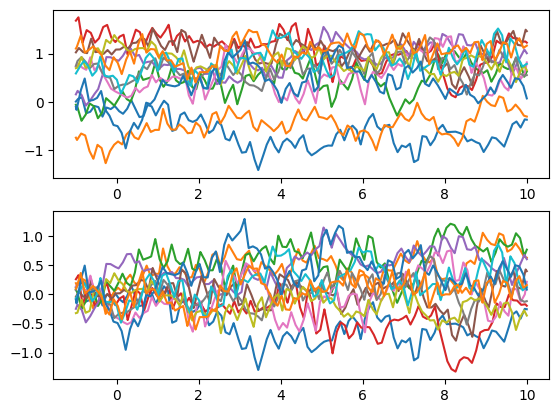

In [18]:
fig, ax = plt.subplots(2)

for non_trace, bsl_trace in zip(event_alinged, bsl_event_alinged):
    ax[0].plot(event_alinged.index,event_alinged[non_trace])
    ax[1].plot(bsl_event_alinged.index,bsl_event_alinged[bsl_trace])


In [260]:
event_alinged, bsl_event_alinged = align_to_event_start(B3M8, '470_dfF', 'No_halt',[1,2])

3
3001


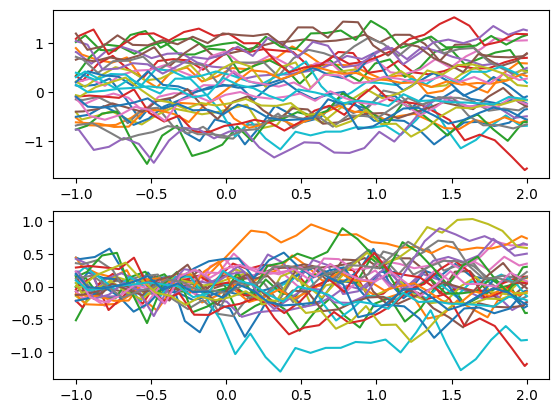

In [261]:
fig, ax = plt.subplots(2)

for non_trace, bsl_trace in zip(event_alinged, bsl_event_alinged):
    ax[0].plot(event_alinged.index,event_alinged[non_trace])
    ax[1].plot(bsl_event_alinged.index,bsl_event_alinged[bsl_trace])


In [220]:
B3M8

,470_dfF,movementX,movementY,halt,ExperimentEvents,Experiment,Session,mouseID,sex,area,No_halt,LinearMismatch_block,LinearPlaybackMismatch_block
Seconds,,,,,,,,,,,,,
30.001,-0.200575,0.049025,1.673691e-02,False,NaN,MMclosed-and-open,day1,B3M8,F,V2M,False,True,False
30.002,-0.197610,0.049249,1.468330e-02,False,NaN,MMclosed-and-open,day1,B3M8,F,V2M,False,True,False
30.003,-0.194645,0.049473,1.262969e-02,False,NaN,MMclosed-and-open,day1,B3M8,F,V2M,False,True,False
30.004,-0.191681,0.049711,1.065309e-02,False,NaN,MMclosed-and-open,day1,B3M8,F,V2M,False,True,False
30.005,-0.188716,0.050112,9.613453e-03,False,NaN,MMclosed-and-open,day1,B3M8,F,V2M,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936.876,-0.020271,0.000099,3.627770e-05,False,NaN,MMclosed-and-open,day1,B3M8,F,V2M,False,False,False
1936.877,-0.019179,0.000073,2.660365e-05,False,NaN,MMclosed-and-open,day1,B3M8,F,V2M,False,False,False
1936.878,-0.018087,0.000046,1.692959e-05,False,NaN,MMclosed-and-open,day1,B3M8,F,V2M,False,False,False
